In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline

torch.set_default_dtype(torch.float64)

from sklearn.metrics import r2_score
import dill

In [25]:
# hand_train = np.load('hand_train.npy').transpose(1,0,2)
# hand_train = torch.Tensor(hand_train)
# hand_train = hand_train[:, ...]
# C_prime = Tensor(np.load('C.npy'))
# _R = np.load('new_data.npz')['hand_KF_R']
# # _R_half = torch.Tensor(np.linalg.cholesky(_R))
# # p = Preprocessor(hand_train, 10, W=C_prime, R_half=_R_half)
# _R_half = torch.Tensor(np.linalg.cholesky(_R-np.eye(2)*1e-6))
# _R_half = torch.tril(_R_half, diagonal=-1) + torch.diag(torch.log(torch.diag(_R_half)))
# p = Preprocessor(hand_train, 10, W=C_prime, R_half=_R_half)
# p.A.data = torch.Tensor(np.load('A.npy'))
# Q = torch.Tensor(np.load('Q.npy'))
# p.B.data = torch.linalg.cholesky(Q)
# p.mu0.data = torch.Tensor(np.load('mu0.npy'))
# p.Sigma0_half.data = torch.Tensor(np.linalg.cholesky(np.load('Sigma0.npy')))
# p.freeze_params()
# pickle.dump(p, open('4g10preprocess/50ms.pkl', 'wb'))

In [24]:
# print(p.mu0.detach().cpu().numpy() - np.load('mu0.npy'))
# print(p.A.detach().cpu().numpy() - np.load('A.npy'))
# print(p.Q.detach().cpu().numpy() - np.load('Q.npy'))
# print(p.Sigma0.detach().cpu().numpy() - np.load('Sigma0.npy'))
# print(p.W.detach().cpu() - C_prime)
# print(p.R.detach().cpu().numpy() - _R)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 1.00000000e-06  0.00000000e+00  1.11022302e-16  5.55111512e-17
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.22044605e-16
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-06 -1.11022302e-16 -5.55111512e-17
   5.55111512e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.11022302e-16 -1.11022302e-16  1.00000000e-06 -4.85722573e-17
  -1.11022302e-16  0.00000000e+00 -5.55111512e-17  0.00000000e+00
  -1.38777878e-16  0.00000000e+00]
 [ 5.55111512e-17 -5.55111512e-17 -4.85722573e-17  1.00000000e-06
   1.38777878e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2

(2, 400, 80)


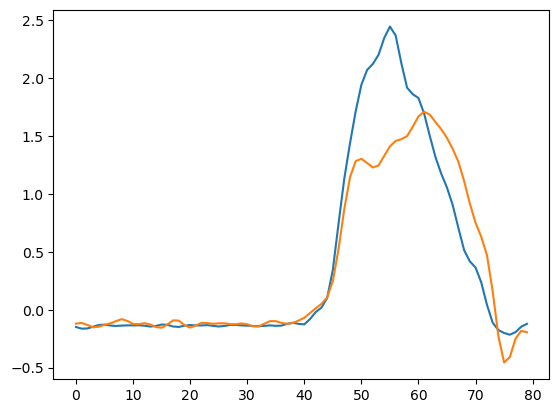

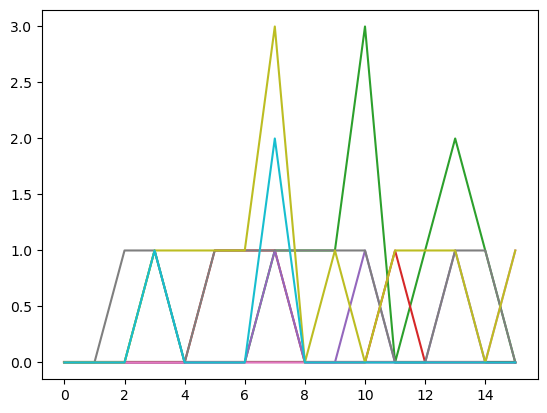

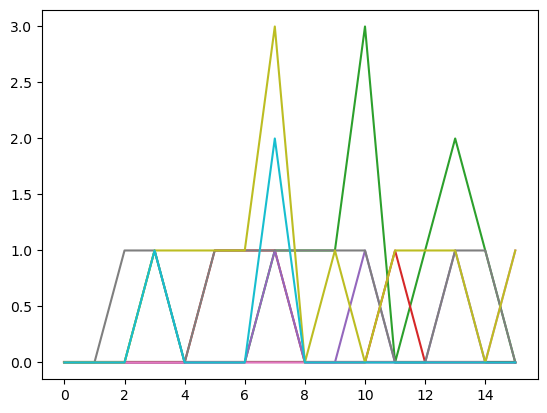

In [17]:
# data = np.load('data_10ms.npz')
# hand_train = data['hand_train']
# hand_test = data['hand_test']
# neural_train = data['neural_train']
# neural_test = data['neural_test']
# print(hand_train.shape)
# plt.plot(hand_train[:,0,:].T)
# plt.show()


# # plt.plot(neural_train[:10,0,:].T)
# # plt.show()
# neural_train = neural_train[:10,0,:].T

# # Reshape the array to shape (16, 5, 10)
# reshaped_neural_train = neural_train.reshape(-1, 5, neural_train.shape[1])

# # Sum along the second axis to get an array of shape (16, 10)
# summed_neural_train = reshaped_neural_train.sum(axis=1)

# # Now you can plot your data
# plt.plot(summed_neural_train)
# plt.show()

# data = np.load('new_data.npz')
# neural_train = data['neural_train']
# plt.plot(neural_train[:10,0,:].T)
# plt.show()  


In [2]:
# Train 4G10 model
# z = np.load('4G10_z.npy')
# z = z.transpose(1,0, 2)
z = np.load('4G10_z_ayush.npy')
print(z.shape)
z = torch.Tensor(z)

Y_train = np.load('neural_train.npy')
Y_train = Y_train.transpose(1,0,2)
Y_train = torch.Tensor(Y_train)
print(Y_train.shape)

Y_test = np.load('neural_test.npy')
Y_test = Y_test.transpose(1,0,2)
Y_test = torch.Tensor(Y_test)
print(Y_test.shape)



(400, 10, 16)
torch.Size([400, 162, 16])
torch.Size([100, 162, 16])


tensor([0.1023, 0.1711, 0.5150, 0.1553, 0.3377, 0.0291, 0.2096, 0.8529, 0.5342,
        0.4148, 0.1994, 0.0303, 0.0791, 1.2572, 0.0910, 0.8965, 0.3662, 0.0525,
        0.0348, 0.2645, 0.1555, 0.7842, 1.3041, 0.3535, 0.4150, 0.2262, 0.3520,
        0.5375, 0.2432, 0.4504, 0.0123, 0.2645, 0.1229, 0.1521, 0.3779, 0.2332,
        0.0055, 0.7191, 0.0266, 0.1424, 0.2758, 0.3250, 0.1600, 0.1961, 0.2400,
        0.5227, 0.1855, 0.1615, 0.1412, 0.4430, 0.3865, 0.3096, 0.4412, 0.2895,
        0.0170, 0.4852, 0.2123, 0.5924, 0.0334, 0.1574, 0.1877, 0.2029, 0.0656,
        0.3236, 0.4859, 0.3006, 0.6943, 0.3084, 0.0090, 0.4633, 0.0941, 0.2191,
        0.2338, 0.4986, 0.1295, 0.9152, 0.3830, 0.1848, 0.0555, 0.3355, 0.0492,
        0.0262, 0.4537, 0.0551, 0.1014, 0.2844, 0.3187, 0.0793, 0.4197, 0.3180,
        0.0650, 0.5121, 0.7711, 0.1262, 0.8074, 0.2336, 0.3979, 0.2195, 0.1879,
        0.3779, 0.1301, 0.2045, 0.0820, 0.2865, 0.6920, 0.2469, 0.0687, 0.3035,
        0.2936, 0.3449, 0.1834, 0.0836, 

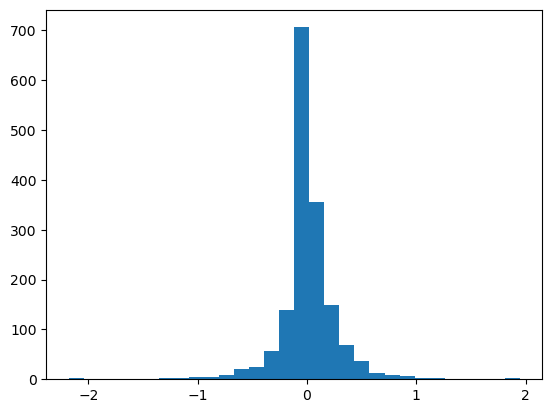

In [3]:


# min_firing_rate = 0.1 # Hz
min_firing_rate = 0. # Hz
T_trial = 16 * 50 /1000 # seconds
print(Y_train.mean(dim=(0, 2))/T_trial)
_Y_train = Y_train[:, Y_train.mean(dim=(0, 2))/T_trial > min_firing_rate, :]
_Y_test = Y_test[:, Y_train.mean(dim=(0, 2))/T_trial > min_firing_rate, :]
print(_Y_train.shape)
print(_Y_test.shape)

__W = np.load('4G10D.npy')
plt.hist(__W.flatten(), bins=30)
print(np.std(__W), 1/np.sqrt(10))


In [4]:
A = np.load('A.npy')
A = torch.Tensor(A[None, ...]).to(device)
Q = np.load('Q.npy')
B = np.linalg.cholesky(Q)
B = torch.Tensor(B[None, ...]).to(device)
mu0 = np.load('mu0.npy')
mu0 = torch.Tensor(mu0[None, ...]).to(device)
Sigma0 = np.load('Sigma0.npy')
Sigma0_half = np.linalg.cholesky(Sigma0)
Sigma0_half = torch.Tensor(Sigma0_half[None, ...]).to(device)

np.random.seed(0)
torch.manual_seed(0)

# link_fn = torch.functional.F.softplus
link_fn = torch.exp
lik = Poisson_noise()
x_dim = 162
# x_dim = 500
# _W = torch.randn(1, x_dim,10).to(device) / np.sqrt(10)
_W = torch.tensor(np.load('4G10D.npy')[None, ...]).to(device)


# # # link_fn = lambda x: x
# def link_fn(x):
#     return x
# lik = Gaussian_noise(0.1)
# x_dim = 162
# # _W = torch.randn(1, x_dim,10).to(device) / np.sqrt(10)
# _W = torch.tensor(np.load('4G10D.npy')[None, ...]).to(device)
# _Y_train = _Y_train - torch.mean(_Y_train, dim=2, keepdim=True)

# link_fn = lambda x: x
# lik = Negative_binomial_noise(Tensor(_Y_train))


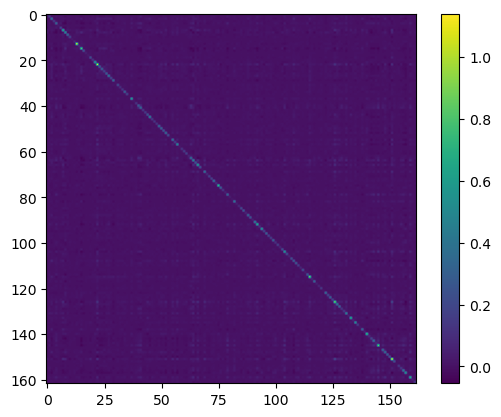

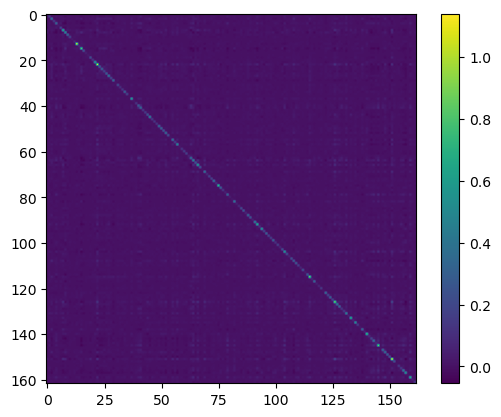

torch.Size([162, 162])
162 16 162 10 400
step 0 LL -0.6131813441500663
step 1 LL -0.6123004278483102
step 2 LL -0.6115616760066918
step 3 LL -0.6107246094298684
step 4 LL -0.6098763384255782
step 5 LL -0.609116075560394
step 6 LL -0.6085962869585139
step 7 LL -0.6078139265854221
step 8 LL -0.6070974192643779
step 9 LL -0.6064028855686117
step 10 LL -0.6057709819901289
step 11 LL -0.6050330557235903
step 12 LL -0.604477460346355
step 13 LL -0.6034940552401935
step 14 LL -0.6031989809442717
step 15 LL -0.6024967630748982
step 16 LL -0.6017409726069427
step 17 LL -0.6012322405048959
step 18 LL -0.6005829548092111
step 19 LL -0.6001619187145428
step 20 LL -0.599643132069924
step 21 LL -0.5991486371000397
step 22 LL -0.5983721724458043
step 23 LL -0.5979473114324583


KeyboardInterrupt: 

In [10]:
# # model = LDS(z, _Y_train, lik, link_fn=link_fn)

model = LDS(z[:, ...], _Y_train[:, ...], lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=True, fixed_d=False, x_dim=x_dim, single_sigma_x=False, full_R=True, d=-2, analytical_init=True, W=_W)

model.C.data = torch.eye(model.N).to(device)
model.C.requires_grad = False
R_half = Tensor(np.linalg.cholesky(np.load('4G10S.npy'))).to(device)
print(R_half.shape)
model.R_half.data = R_half

model.R_half.requires_grad = False
model.W.requires_grad = False

# model.log_sigma_x.data = torch.log(torch.diag(R_half)).to(device)

# model = dill.load(open('4g10datamodels/poisson_big.pkl', 'rb'))
# model.freeze_params()
# model.log_sigma_x.requires_grad = True
# model.W.requires_grad = True
# model.d.requires_grad = True

print(model.N, model.T, model.x_dim, model.b, model.ntrials)
# train_params = {'batch_size': None, 'n_mc': 100, 'lrate': 7.5e-2, 'max_steps': 1001, 'step_size': 200}
# train_params = {'batch_size': None, 'n_mc': 50, 'lrate': 5e-3, 'max_steps': 1001, 'step_size': 1000, 'StepLR': True}
train_params = {'batch_size': None, 'n_mc': 50, 'lrate': 1e-2, 'max_steps': 1001, 'step_size': 1000, 'StepLR': True}
# train_params = {'batch_size': None, 'n_mc': 25, 'lrate': 5e-3, 'max_steps': 1001, 'step_size': 200, 'StepLR': True}

# for prm in model.parameters():
#     prm.requires_grad = True

model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

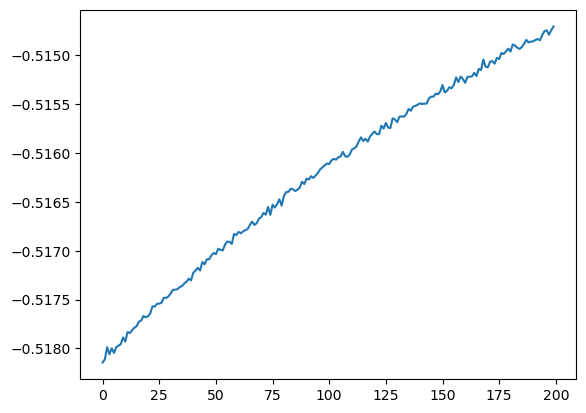

In [7]:
plt.plot(model.LLs[-200:])
plt.show()

In [5]:
# pickle.dump(model, open('4g10datamodels/gaussian.pkl', 'wb'))
# dill.dump(model, open('4g10datamodels/gaussian.pkl', 'wb'))
# model = dill.load(open('4g10datamodels/gaussian.pkl', 'rb'))
# model = pickle.load(open('4g10datamodels/poisson_gen_model_working.pkl', 'rb'))
# pickle.dump(model, open('4g10datamodels/poisson_new_good.pkl', 'wb'))
# dill.dump(model, open('4g10datamodels/poisson_big.pkl', 'wb'))
# model = dill.load(open('4g10datamodels/poisson_big.pkl', 'rb'))

# dill.dump(model, open('4g10datamodels/poisson_big_full_R.pkl', 'wb'))
# dill.dump(model, open('4g10datamodels/poisson_big_full_R_good_init.pkl', 'wb'))
# model = dill.load(open('4g10datamodels/poisson_big_full_R_good_init.pkl', 'rb'))

# dill.dump(rec_model.gen_model, open('4g10datamodels/poisson_big_full_R_D_S_init.pkl', 'wb'))

# dill.dump(model, open('4g10datamodels/poisson_d_var.pkl', 'wb'))
# model = dill.load(open('4g10datamodels/poisson_d_var.pkl', 'rb'))
# model = dill.load(open('4g10datamodels/first.pkl', 'rb'))
# dill.dump(model, open('4g10datamodels/exp_link.pkl', 'wb'))
# model = dill.load(open('4g10datamodels/xdim_500.pkl', 'rb'))
# model = dill.load(open('4g10datamodels/new10.pkl', 'rb'))
# model = dill.load(open('4g10datamodels/third.pkl', 'rb'))
# model = dill.load(open('4g10datamodels/first.pkl', 'rb'))
# model = dill.load(open('4g10datamodels/full_R.pkl', 'rb'))
# plt.plot(np.diag((model.R_half - torch.linalg.cholesky(model2.R)).detach().cpu().numpy().squeeze()))
# plt.show()

# model = dill.load(open('4g10datamodels/first_repeat_gen.pkl', 'rb'))
model = dill.load(open('4g10datamodels/third_repeat_gen.pkl', 'rb'))

tensor([[-2.3129, -2.8921,  1.2958,  4.6284,  3.3780,  0.7671, -0.4289,  1.1848,
         -6.3311, -1.7821, -3.0147, -7.0587, -1.2625, -1.4095, -1.6899, -2.1268,
         -0.0789,  3.3920,  0.7583, -4.4010,  1.7631,  2.9604,  0.2628,  1.8897,
          3.0993, -2.8260, -1.2035,  2.5587,  1.0649,  1.9199, -5.8989,  0.5968,
         -1.0021,  6.7791,  4.0430,  0.7627, -0.4964,  0.8414, -1.6137, -2.0455,
         -3.2459, -2.1045,  1.3558,  1.3259, -3.1316, -0.2684,  1.4740,  4.0341,
         -0.2174,  2.4021,  1.1396, -0.3337,  8.4819,  1.3792, -0.3081, -0.9161,
         -0.8277, -0.4311,  3.7318,  2.5120,  0.3494,  0.6766, -3.8374, -6.5505,
          0.6040, -2.0056,  1.2288,  2.0942, -0.3508,  3.1247, -3.4276,  0.0964,
          1.6615,  1.1307, -0.8139, -1.6592,  0.3476,  1.1873,  0.5396,  0.6362,
         -1.8571, -6.0894, -1.1834,  0.5904,  0.7232,  0.3754,  0.6492, -2.7014,
         -0.7073,  0.0261, -0.1048,  0.5189, -0.0926, -0.8981,  0.3323, -1.0903,
          0.3656, -0.1763,  

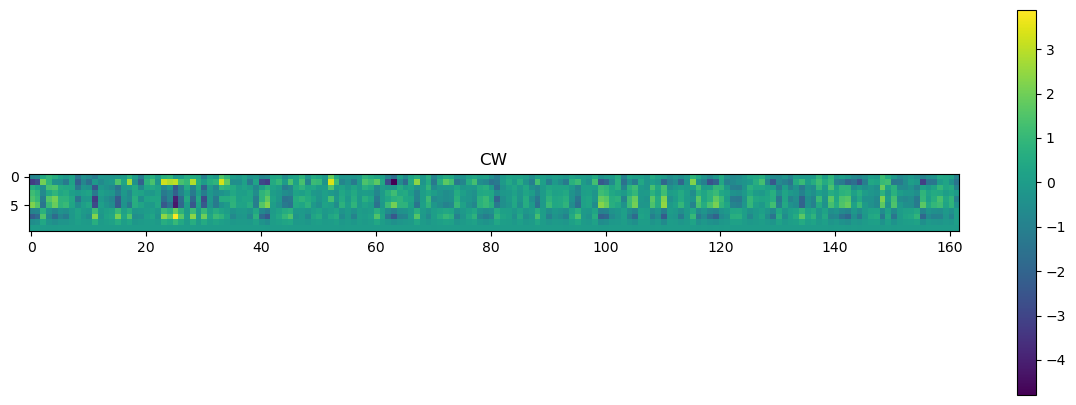

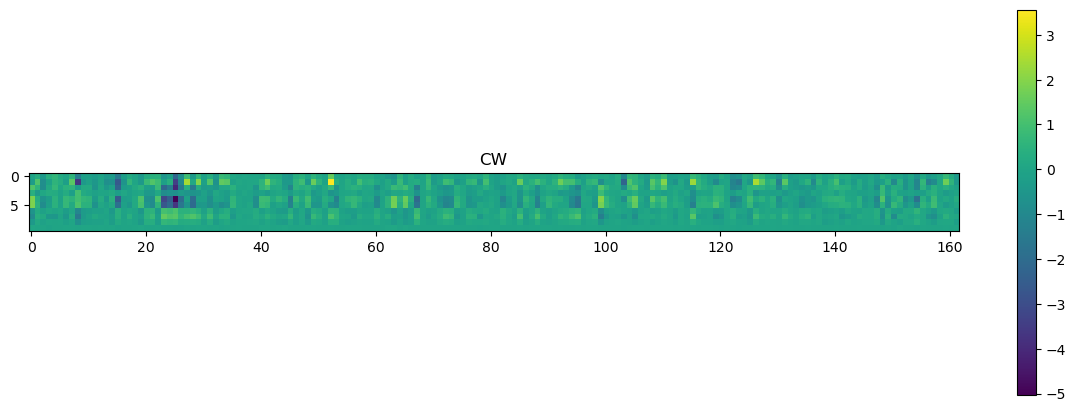

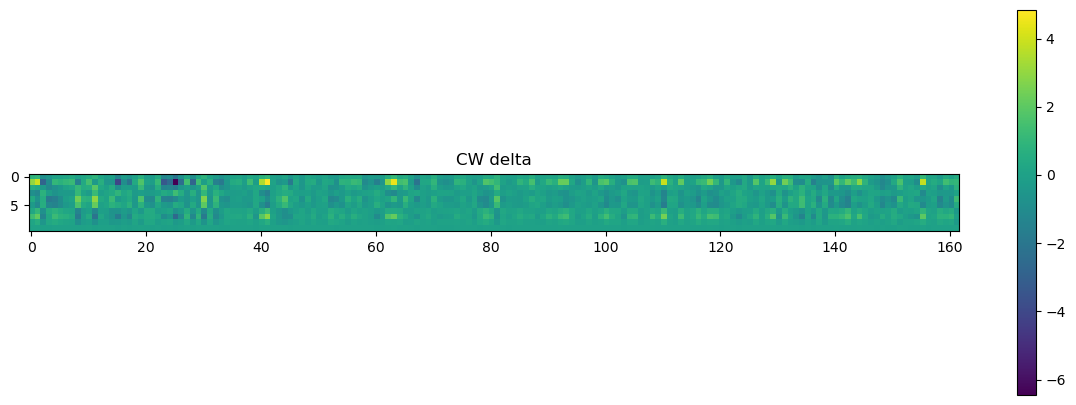

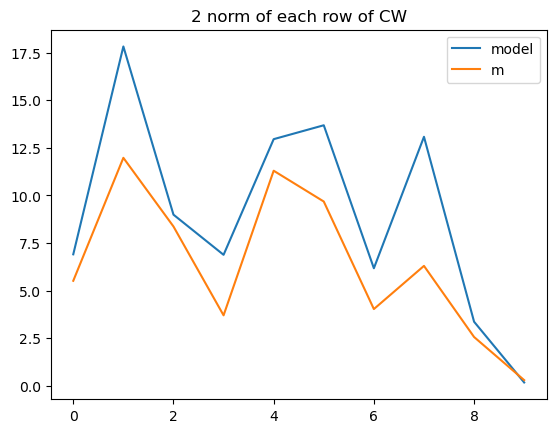

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


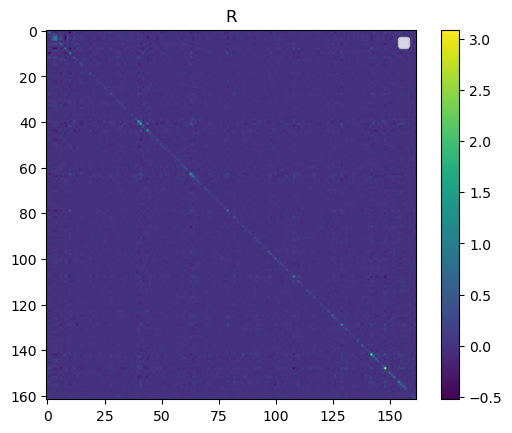

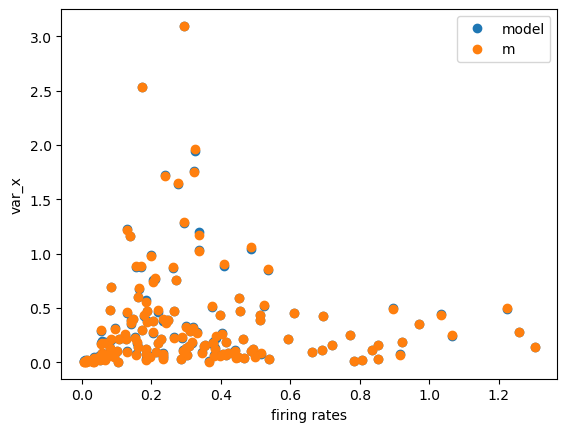

Text(0, 0.5, 'd')

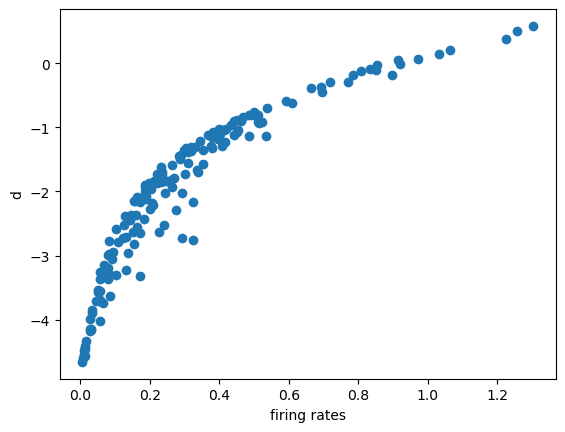

In [13]:
# model.freeze_params()

# for name, prm in model.named_parameters():
#     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')

# # print(Q - (B @ B.transpose(-1,-2)).detach().cpu().numpy())
# print('d', model.d)
# print('sigma_x', model.sigma_x)
# print('Q', torch.diag(model.Q[0]))
print((model.C @ model.W).sum(axis=-1))
# print(model.lik.sigma)

# # print(torch.linalg.det(model.Sigma0))
# # # min eigenvalue of Sigma0
# # min_abs_eigenvalue = torch.abs(torch.linalg.eigvals(model.Sigma0)).min()
# # print(min_abs_eigenvalue)

# # # print(model.lik.total_count)

# # print(model.Q)

# plt.imshow(model.Q[0].detach().cpu().numpy() - np.load('Q.npy'))
# plt.colorbar()
# plt.show()

# -------------------
# plt.figure(figsize=(15, 5))  
# plt.imshow(model.W[0].detach().cpu().numpy().T)
# plt.colorbar(orientation='horizontal')
# plt.title('W')
# plt.show()

# plt.figure(figsize=(15, 5))  # Adjust as needed
# plt.imshow(model.C[0].detach().cpu().numpy())
# plt.colorbar(orientation='horizontal')
# plt.title('C')
# plt.show()

# plt.hist(model.W.detach().cpu().numpy().flatten(), bins=30)
# plt.title('W')
# print(np.std(model.W.detach().cpu().numpy()))
# plt.show()

# plt.hist(model.C.detach().cpu().numpy().flatten(), bins=30)
# plt.title('C')
# print(np.std(model.C.detach().cpu().numpy()))
# plt.show()

plt.figure(figsize=(15, 5))  # Adjust as needed
plt.imshow((model.C @ model.W)[0].detach().cpu().numpy().T)
plt.colorbar()
plt.title('CW')
plt.show()

plt.figure(figsize=(15, 5))  # Adjust as needed
# m = dill.load(open('4g10datamodels/poisson_big.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first.pkl', 'rb'))
m = dill.load(open('4g10datamodels/new_full_R.pkl', 'rb'))
plt.imshow((m.C @ m.W)[0].detach().cpu().numpy().T)
plt.colorbar()
plt.title('CW')
plt.show()

plt.figure(figsize=(15, 5))  # Adjust as needed
plt.imshow((m.C @ m.W)[0].detach().cpu().numpy().T - (model.C @ model.W)[0].detach().cpu().numpy().T)
plt.colorbar()
plt.title('CW delta')
plt.show()

# plot 2 norm of each row of CW
plt.plot(torch.linalg.norm((model.C @ model.W)[0], dim=0).detach().cpu().numpy(), label='model')
plt.plot(torch.linalg.norm((m.C @ m.W)[0], dim=0).detach().cpu().numpy(), label='m')
plt.legend()
plt.title('2 norm of each row of CW')
plt.show()

plt.imshow(model.R.squeeze(0).detach().cpu().numpy())
plt.colorbar()
plt.title('R')
# plot neuron firing rates
# plt.plot(_Y_train.mean(dim=(0,2))/T_trial, 'x', label='firing rates')
plt.legend()
plt.show()

# # plot Delta R between model and m
# plt.imshow((model.R.squeeze(0) - m.R.squeeze(0)).detach().cpu().numpy())
# plt.colorbar()
# plt.title('Delta R')
# plt.show()

plt.plot(_Y_train.mean(dim=(0,2))/T_trial, torch.diag(model.R.squeeze()).detach().cpu().numpy(), 'o', label='model')
plt.plot(_Y_train.mean(dim=(0,2))/T_trial, torch.diag(m.R.squeeze()).detach().cpu().numpy(), 'o', label='m')
# plt.plot(_Y_train.mean(dim=(0,2))/T_trial, torch.square(torch.exp(m.log_sigma_x)).detach().cpu().numpy(), 'o')
plt.legend()
plt.xlabel('firing rates')
plt.ylabel('var_x')
plt.show()


plt.plot(_Y_train.mean(dim=(0,2))/T_trial, model.d.detach().cpu().numpy(), 'o')
plt.xlabel('firing rates')
plt.ylabel('d')
# print(model.lik.sigma, 'sigma')
# print(min(model.sigma_x), max(model.sigma_x), 'sigma_x')

# plt.hist(model.d.detach().cpu().numpy(), bins=30)
# plt.title('d')
# plt.show()
# plt.hist(model.sigma_x.detach().cpu().numpy(), bins=30)
# plt.title('sigma_x')
# plt.show()

torch.Size([3, 1, 10, 16])


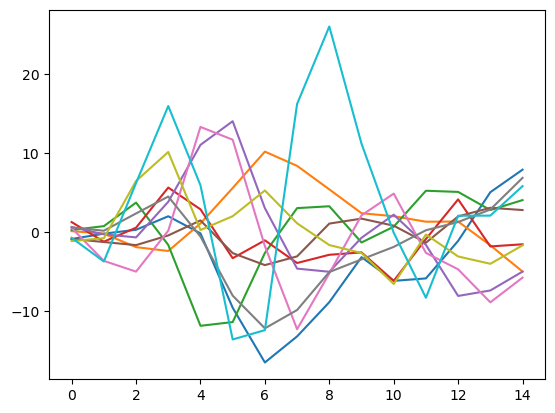

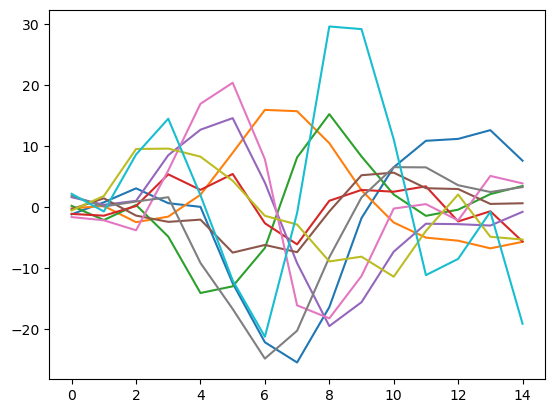

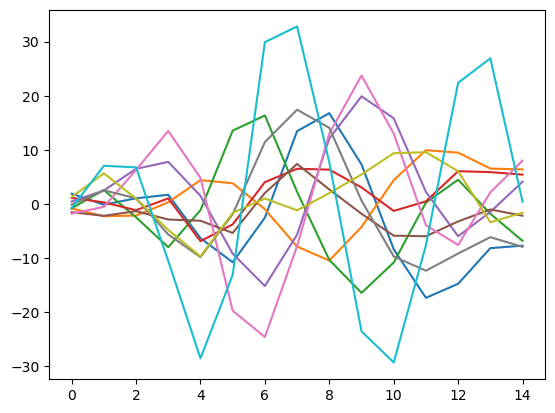

In [5]:
z_samps = model.sample_z(3, 1)
print(z_samps.shape)
stop = -1
for i in range(len(z_samps)):
    for j in range(10):
        plt.plot(z_samps[i,0,j, :stop].detach().cpu().numpy())
    plt.show()

In [7]:
hand_train = np.load('hand_train.npy').transpose(1,0,2)
hand_train = torch.Tensor(hand_train)
hand_train = hand_train[:, ...]
C_prime = Tensor(np.load('C.npy'))
_R = np.load('new_data.npz')['hand_KF_R']
_R_half = torch.Tensor(np.linalg.cholesky(_R))
p = Preprocessor(hand_train, 10, W=C_prime, R_half=_R_half)
p.freeze_params()

In [8]:
model.freeze_params()
model.W.requires_grad = True
model.d.requires_grad = True
# model.log_sigma_x.requires_grad = True
model.R_half.requires_grad = True
torch.manual_seed(0)
np.random.seed(0)
class MyRNNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
        self.fc = torch.nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = MyRNNModel(model.N, 100, model.x_dim)

neural_net = MyRNNModel(162, 100, 162)
def init_weights(neural_net, spikes):
    # Initialize weights such that the RNN output is the same as input spikes
    # spikes: (ntrials, N, T)
    # neural_net: RNN model
    # Returns: None
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(neural_net.parameters())

    # Number of epochs
    epochs = 1000


    # Training loop
    for epoch in range(epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        # outputs = model(Y)
        outputs = neural_net(Y_train.transpose(1, 2))

        # Compute loss
        # loss = criterion(outputs, x_noise_free_train.transpose(1, 2))
        loss = criterion(outputs, Y_train.transpose(1, 2))

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# init_weights(neural_net, Y_train)

# rec_model = RecognitionModel(model, neural_net=neural_net, zero_mean_x_tilde=True)
neural_net = pickle.load(open('4g10datamodels/neural_net_init.pkl', 'rb'))
rec_model = RecognitionModel(model, rnn=True, neural_net=neural_net, zero_mean_x_tilde=True, preprocessor=p, gen_model_fixed=False)

# # rec_model = RecognitionModel(model, rnn=True)
# # train_params = {'batch_size': 100, 'step_size': 10, 'lrate': 1e-2, 'max_steps': 1001, 'n_mc_x': 20, 'n_mc_z': 20, 'batch_mc_z': 20}
print(rec_model.gen_model.ntrials)
train_params = {'batch_size': 200, 'step_size': 1000, 'lrate': 5e-3, 'max_steps': 1001, 'n_mc_x': 10, 'n_mc_z': 10, 'batch_mc_z': 10}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

400
step 0 LL -88.0412 Entropy -2.4706 ln p(y|z) -0.5702 ln p(z) -699.8228 ln p(v|z) -3661.7289
step 1 LL -58.0091 Entropy -2.7687 ln p(y|z) -0.5678 ln p(z) -428.9420 ln p(v|z) -2552.1987
step 2 LL -62.3215 Entropy -2.9867 ln p(y|z) -0.5612 ln p(z) -401.6679 ln p(v|z) -3041.6306
step 3 LL -38.4864 Entropy -3.0641 ln p(y|z) -0.5603 ln p(z) -163.3351 ln p(v|z) -2278.5023
step 4 LL -29.6410 Entropy -3.0897 ln p(y|z) -0.5636 ln p(z) -72.3537 ln p(v|z) -2007.6965
step 5 LL -26.0939 Entropy -3.1056 ln p(y|z) -0.5664 ln p(z) -40.8520 ln p(v|z) -1874.0326
step 6 LL -24.5288 Entropy -3.1179 ln p(y|z) -0.5683 ln p(z) -34.9631 ln p(v|z) -1774.9241
step 7 LL -24.0572 Entropy -3.1297 ln p(y|z) -0.5706 ln p(z) -36.1914 ln p(v|z) -1729.8653
step 8 LL -23.2479 Entropy -3.1402 ln p(y|z) -0.5723 ln p(z) -34.5621 ln p(v|z) -1671.4576
step 9 LL -23.3000 Entropy -3.1507 ln p(y|z) -0.5746 ln p(z) -29.0336 ln p(v|z) -1703.1364
step 10 LL -23.2333 Entropy -3.1634 ln p(y|z) -0.5766 ln p(z) -24.4846 ln p(v|z) -

KeyboardInterrupt: 

/home/ayush/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


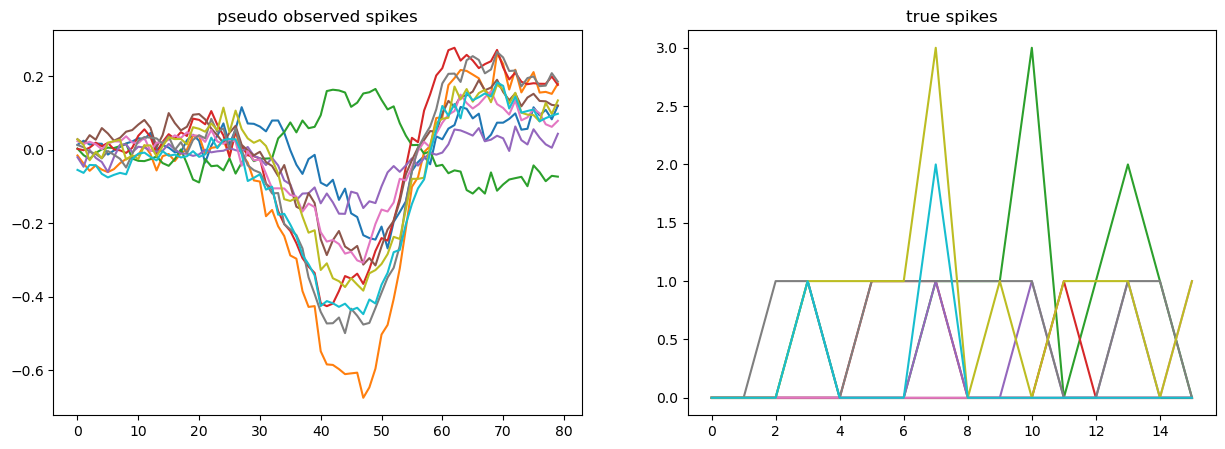

In [7]:
# neural_net = pickle.load(open('4g10datamodels/neural_net_init.pkl', 'rb')).to(device)
# print(neural_net(Y_train.transpose(1, 2)).shape)
# plt.plot(neural_net(Y_train.transpose(1, 2)).transpose(1,2)[0, 0, :].detach().cpu().numpy())
neural_net = rec_model.neural_net
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for n in range(10):
    ax[0].plot(neural_net(rec_model.gen_model.Y.transpose(1, 2)).transpose(1,2)[0, n, :].detach().cpu().numpy())
    # ax[0].plot(neural_net(rec_model.gen_model.Y.transpose(1, 2))['x_tilde'].transpose(1,2)[0, n, :].detach().cpu().numpy())
# plt.show()
for n in range(10):
    ax[1].plot(Y_train[0, n, :].detach().cpu().numpy())   
ax[0].set_title('pseudo observed spikes')
ax[1].set_title('true spikes')
plt.show()

# pickle.dump(neural_net, open('4g10datamodels/neural_net_init.pkl', 'wb'))


/home/ayush/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


(400, 10, 80) (100, 10, 16)
(2, 10)
(400, 2, 80) (100, 2, 16)


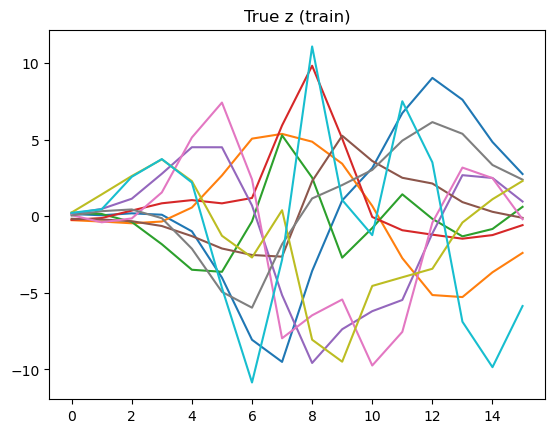

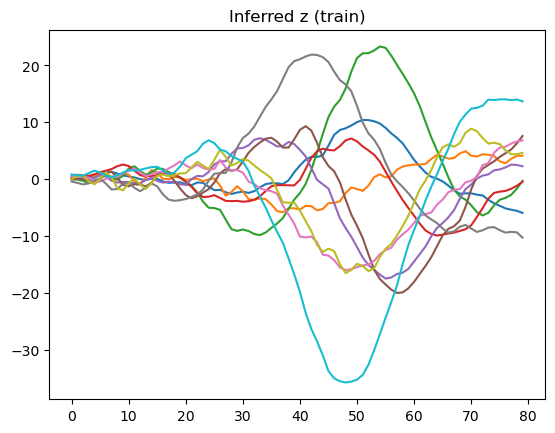

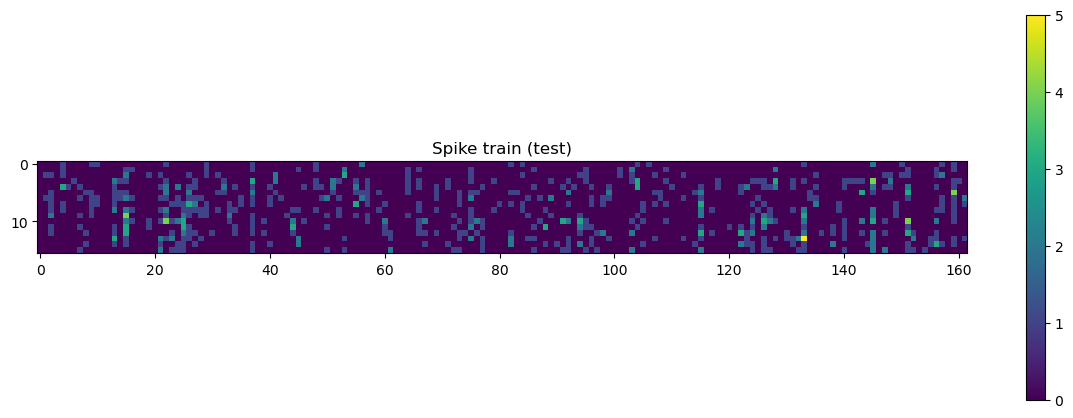

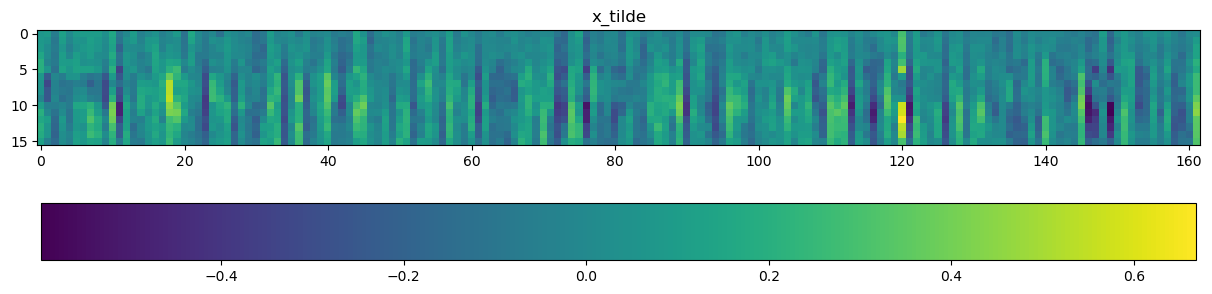

(162, 16)


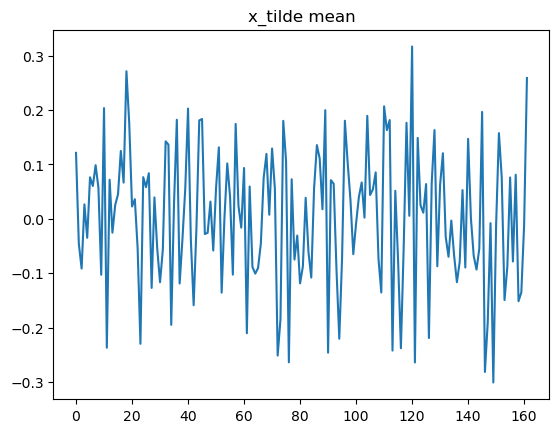

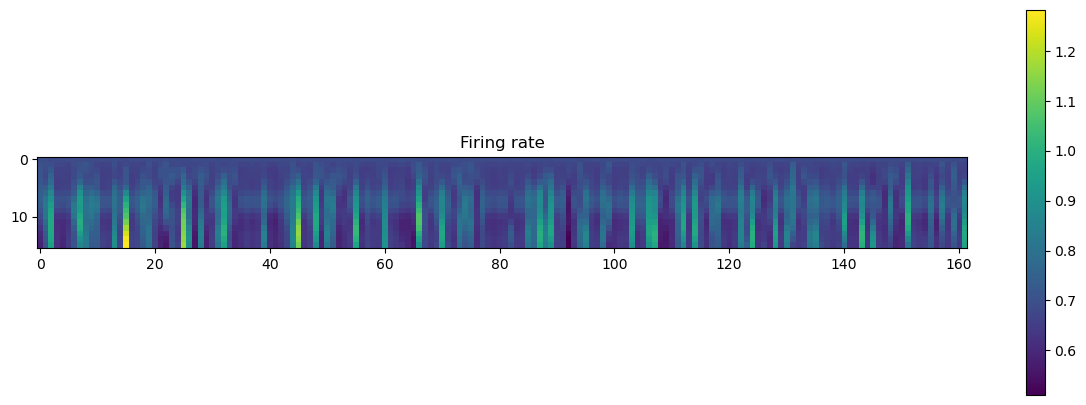

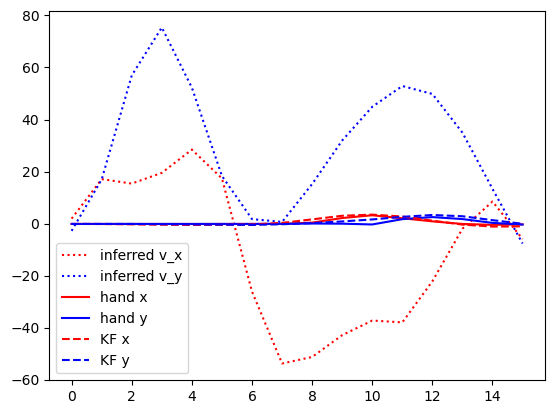

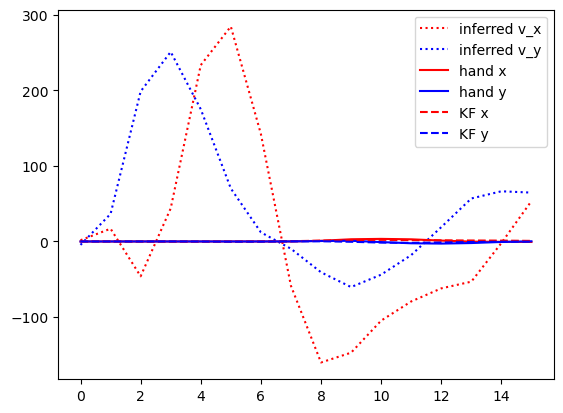

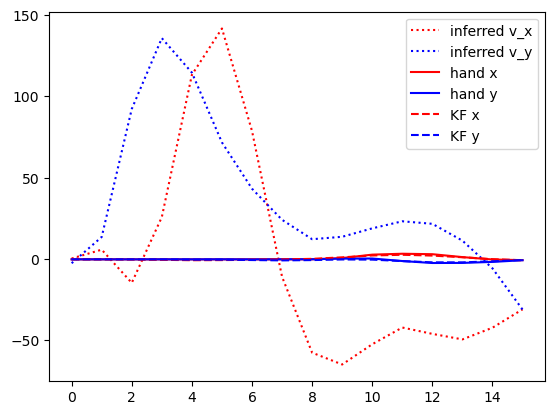

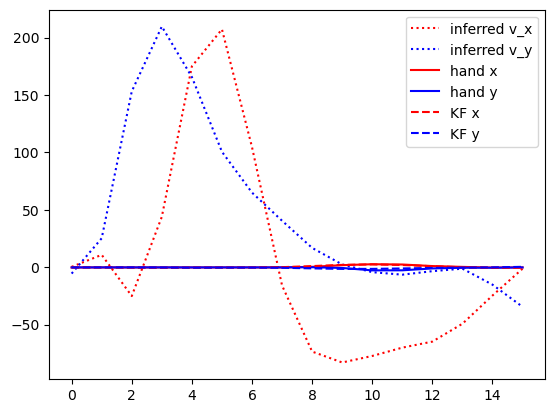

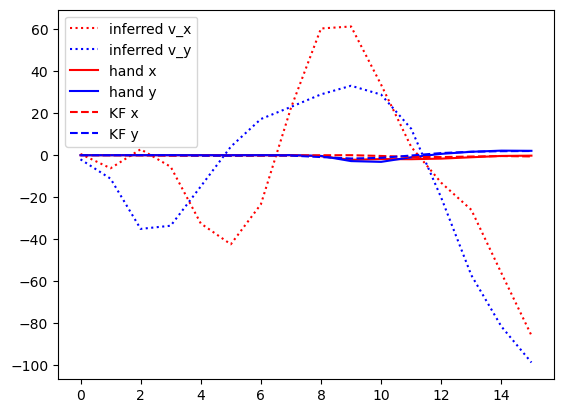

x test -4265.473167835965 y test -4256.4370123177605 avg -4260.955090076863
x test cw 0.7630658505333294 y test cw 0.6656336091357513 avg cw 0.7143497298345404


In [6]:
# rec_model.gen_model.link_fn = lambda x: 1* torch.nn.functional.softplus(x)
# rec_model.gen_model.link_fn = torch.exp
rec_model.freeze_params()
z_train = rec_model.test_z(rec_model.gen_model.Y)
z_test = rec_model.test_z(Tensor(_Y_test).to(device))
z_train = z_train.detach().cpu().numpy()
z_test = z_test.detach().cpu().numpy()
print(z_train.shape, z_test.shape)

C = np.load('C.npy')
print(C.shape)
v_train = (C[None, ...] @ z_train)
v_test = (C[None, ...] @ z_test)
print(v_train.shape, v_test.shape)

hand_train = np.load('hand_train.npy')
hand_train = hand_train.transpose(1,0,2)
hand_test = np.load('new_data.npz')['hand_test']
hand_test = hand_test.transpose(1,0,2)

true_z = np.load('4G10_z_ayush.npy')
for trial in range(1):
    for j in range(10):
        plt.plot(true_z[trial, j, :])
plt.title('True z (train)')
plt.show()
for trial in range(1):
    for j in range(10):
        plt.plot(z_train[trial, j, :])
plt.title('Inferred z (train)')
plt.show()

for trial in range(1):
    plt.figure(figsize=(15, 5))  # Adjust as needed
    # plt.imshow(_Y_train[trial].T)
    plt.imshow(_Y_test[trial].T)
    plt.colorbar()
    plt.title('Spike train (test)')
    plt.show()
    plt.figure(figsize=(15, 5))  # Adjust as needed
    # plt.imshow(rec_model.get_x_tilde(rec_model.gen_model.Y).detach().cpu().numpy()[trial].T)
    pseudo_obs = rec_model.get_x_tilde(Tensor(_Y_test).to(device), only_x_tilde=False)
    x_tilde = pseudo_obs['x_tilde'].detach().cpu().numpy()[trial].T
    plt.imshow(x_tilde)
    # plt.imshow(rec_model.get_x_tilde(Tensor(_Y_test).to(device)).detach().cpu().numpy()[trial].T)
    plt.colorbar(orientation='horizontal')
    plt.title('x_tilde')
    plt.show()
    # rec_model.zero_mean_x_tilde = False
    print(rec_model.get_x_tilde(Tensor(_Y_test).to(device)).detach().cpu().numpy()[trial].shape)
    plt.plot(rec_model.get_x_tilde(Tensor(_Y_test).to(device)).detach().cpu().numpy()[trial].mean(axis=-1))
    plt.title('x_tilde mean')
    plt.show()
    plt.figure(figsize=(15, 5))  # Adjust as needed
    # plt.imshow(rec_model.gen_model.link_fn(model.C @ model.W @ Tensor(z_train[trial]).to(device) + rec_model.gen_model.d[:, None]).detach().cpu().numpy().T)
    plt.imshow(rec_model.gen_model.link_fn(model.C @ model.W @ Tensor(z_test[trial]).to(device) + rec_model.gen_model.d[:, None]).detach().cpu().numpy().T)
    plt.colorbar()
    plt.title('Firing rate')
    plt.show()

    if pseudo_obs['delta_R'] is not None:
        delta_R = pseudo_obs['delta_R'].detach().cpu().numpy() # (T, ntrials, x_dim)
        for t in range(10):
            plt.plot(delta_R[t, trial, :])
        plt.title('delta_R')
        plt.show()

        if not rec_model.gen_model.full_R:
            plt.plot(rec_model.gen_model.log_sigma_x.detach().cpu().numpy(), label='log_sigma_x')
            plt.legend()
            plt.show()

        new_R = rec_model.gen_model_R(pseudo_obs)[:, trial, ...].detach().cpu().numpy() # (T, x_dim, x_dim)
        R_diag = np.diagonal(new_R, axis1=-1, axis2=-2)
        print(R_diag.shape)
        for t in range(10):
            plt.plot(R_diag[t])
        plt.title('R_diag new')
        plt.show()
        R_orig = rec_model.gen_model_R(pseudo_obs=None).detach().cpu().numpy() # (x_dim, x_dim)
        R_diag_orig = np.diagonal(R_orig, axis1=-1, axis2=-2)
        print(R_diag_orig.shape)
        plt.plot(R_diag_orig)
        plt.title('R_diag orig')
        plt.show()
    if pseudo_obs['delta_W'] is not None:
        delta_W = pseudo_obs['delta_W'].detach().cpu().numpy()
        norms = []
        norms2 = []
        for _trial in range(5):
            norms.append([np.linalg.norm(delta_W[t, _trial] - delta_W[0, _trial], ord='fro') for t in range(16)])
            norms2.append([np.linalg.norm(delta_W[t, _trial], ord='fro') for t in range(16)])
        norms = np.array(norms)
        plt.plot(norms.T)
        plt.title('Frobenius norm of delta_W with respect to first time point')
        plt.show()
        norms2 = np.array(norms2)
        plt.plot(norms2.T)
        plt.title('Frobenius norm of delta_W with respect to true W')
        plt.show()
        
        for t in [0,8,15]:
            plt.figure(figsize=(15, 5))  # Adjust as needed
            # plt.imshow(delta_W[t, trial].T)
            plt.imshow(rec_model.gen_model.W[0].detach().cpu().numpy().T + delta_W[t, trial].T)
            plt.colorbar(orientation='horizontal')
            plt.title('final W')
            plt.show()

cw_v = np.load('KF.npy')
for trial in range(5):
    # plt.plot(v_train[trial,0,:], label = 'inferred v_x', color='red', linestyle='dotted')
    # plt.plot(v_train[trial,1,:], label = 'inferred v_y', color='blue', linestyle='dotted')
    # plt.plot(hand_train[trial,0,:], label = 'hand x', color='red')
    # plt.plot(hand_train[trial,1,:], label = 'hand y', color='blue')
    plt.plot(v_test[trial,0,:], label = 'inferred v_x', color='red', linestyle='dotted')
    plt.plot(v_test[trial,1,:], label = 'inferred v_y', color='blue', linestyle='dotted')
    plt.plot(hand_test[trial,0,:], label = 'hand x', color='red')
    plt.plot(hand_test[trial,1,:], label = 'hand y', color='blue')
    plt.plot(cw_v[0,trial,:], label = 'KF x', color='red', linestyle='dashed')
    plt.plot(cw_v[1,trial,:], label = 'KF y', color='blue', linestyle='dashed')
    plt.legend()
    plt.show()

# trials = 400
v_dim = 2

# print('x train', r2_score(hand_train[:,0,:].flatten(), v_train[:,0,:].flatten()))
# print('y train', r2_score(hand_train[:,1,:].flatten(), v_train[:,1,:].flatten()))
x_test_score = r2_score(hand_test[:,0,:].flatten(), v_test[:,0,:].flatten())
y_test_score = r2_score(hand_test[:,1,:].flatten(), v_test[:,1,:].flatten())
print('x test', x_test_score, 'y test', y_test_score, 'avg', (x_test_score + y_test_score)/2)

x_test_score_cw = r2_score(hand_test[:,0,:].flatten(), cw_v[0].flatten())
y_test_score_cw = r2_score(hand_test[:,1,:].flatten(), cw_v[1].flatten())
print('x test cw', x_test_score_cw, 'y test cw', y_test_score_cw, 'avg cw', (x_test_score_cw + y_test_score_cw)/2)



# r2_scores = np.zeros((v_dim, trials))
# for trial in range(trials):
#     for i in range(v_dim):
#         r2_scores[i, trial] = r2_score(hand_train[trial,i,:], v[trial,i,:])

# # Only consider where r_2 > 0
# print(r2_scores[0][r2_scores[0] > 0].mean())
# print(r2_scores[1][r2_scores[1] > 0].mean())

# def r2(true, pred):
#     return 1 - np.linalg.norm(true - pred, ord='fro')/np.linalg.norm(true - np.mean(true, axis=(-1)), ord='fro')

# for i in range(v_dim):
#     print(r2(hand_train[:,i,:], v[:,i,:]))

# cw_v = np.load('KF.npy')
# z_test = rec_model.test_z(Tensor(_Y_test).to(device))
# z_test = z_test.detach().cpu().numpy()
# v_test = (C[None, ...] @ z_test).transpose(1,0,2)
# print(v_test.shape)

# r2_scores = np.zeros((v_dim, trials))
# for trial in range(v_test.shape[1]):
#     for i in range(v_dim):
#         r2_scores[i, trial] = r2_score(cw_v[i,trial,:], v_test[i,trial,:])
# print(r2_scores[r2_scores > 0].mean())


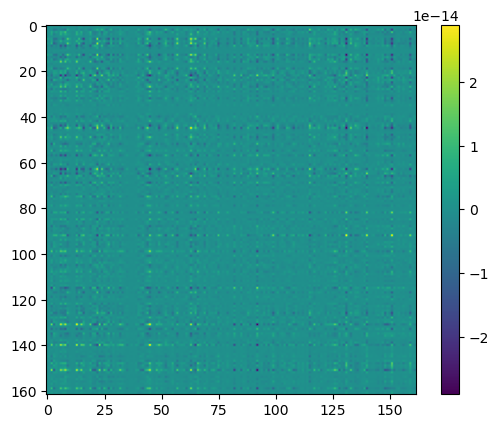

tensor(True, device='cuda:0') tensor(False, device='cuda:0')
assymetry in cov!!
(100, 2, 16)
x test 0.7630772423304321
y test 0.665635472711749


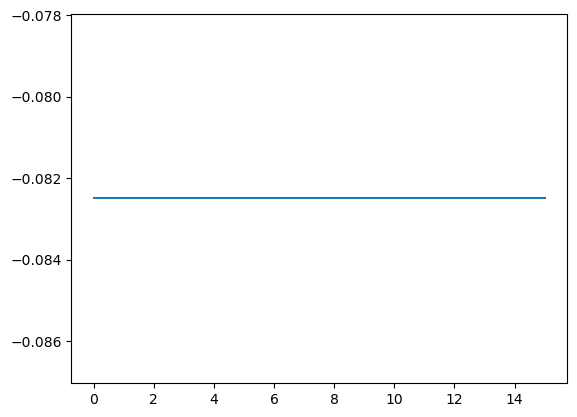

In [10]:
# Verify KF
A = Tensor(np.load('A.npy')).to(device)
W = Tensor(np.load('4G10D.npy')).to(device)
Q = Tensor(np.load('Q.npy')).to(device)
R = Tensor(np.load('4G10S.npy')).to(device)
mu0 = Tensor(np.load('mu0.npy')).to(device)
plt.imshow((R - R.T).detach().cpu().numpy())
plt.colorbar()
plt.show()
Sigma0 = Tensor(np.load('Sigma0.npy')).to(device)
print(is_symmetric(Q), is_symmetric(R))
Sigma0 = Tensor(np.load('Sigma0.npy')).to(device)
_, _, Ks, Cs = general_kalman_covariance(A=A, W=W, Q=Q, R=R, b=10, x_dim=162, Sigma0=Sigma0, T=16)
x_hat = Tensor(Y_test).to(device) - torch.mean(Tensor(Y_test).to(device), dim=(0,2), keepdim=True)[None, ...]
plt.plot(x_hat[0,0,0, :].detach().cpu().numpy())
_ , mus_smooth, _ = general_kalman_means(A=A, W=W, b=10, mu0=mu0, x_hat=x_hat, Ks=Ks, Cs=Cs)
mus_smooth = mus_smooth.squeeze(1) # (T_test, ntrials, b)
mus_smooth = mus_smooth.detach().cpu().numpy().transpose(1, 2, 0)
C = np.load('C.npy')
__v = C[None, ...] @ mus_smooth
print(__v.shape)
hand_test = np.load('new_data.npz')['hand_test']
hand_test = hand_test.transpose(1,0,2)
print('x test', r2_score(hand_test[:,0,:].flatten(), __v[:,0,:].flatten()))
print('y test', r2_score(hand_test[:,1,:].flatten(), __v[:,1,:].flatten()))


In [ ]:
# D = np.load('4G10D.npy')
# S = np.load('4G10S.npy')
# R = torch.Tensor([[0.00038472, 0.00013821], [0.00013821, 0.00043925]]).to(device)
# _, _, Ks, Cs = general_kalman_covariance(A, W, Q, R, 10, 162, p.Sigma0, 10000, smoothing=True)
# _ , mus_smooth, _ = general_kalman_means(p.A, p.W, p.z_dim, p.mu0, Tensor(v[None, ...]).to(device), Ks, Cs=Cs, smoothing=True)


In [5]:
# pickle.dump(rec_model, open('4g10datamodels/gaussian_rec.pkl', 'wb'))
# pickle.dump(rec_model, open('4g10datamodels/poisson_big_finetune_rec.pkl', 'wb'))
# dill.dump(rec_model, open('4g10datamodels/poisson_big_rec.pkl', 'wb'))
# dill.dump(rec_model, open('4g10datamodels/poisson_big_full_R_D_S_rec.pkl', 'wb'))
# dill.dump(rec_model, open('4g10datamodels/exp_link_rec.pkl', 'wb'))

# m = dill.load(open('4g10datamodels/poisson_big_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/poisson_big_finetune_rec.pkl', 'rb'))

# m = dill.load(open('4g10datamodels/first_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_bi_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_lstm_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/xdim_500_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/NB_bi_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_bi_rec_init.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_cov_change.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_bi_rec_mean_removed.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_mc_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_bi_rec_large_hidden.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_cov_change_dr.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_cov_change_dr2.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_bi_rec_init2.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/full_R_bi_rec_init2.pkl', 'rb'))
# R1 = m.gen_model.R.squeeze(0).detach().cpu().numpy()
# m = dill.load(open('4g10datamodels/first_cov_change_dw2.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/first_cov_change_drw.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/second_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/new10_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/third_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/xdim_500_rec_new_elbo.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/new_full_R_rec.pkl', 'rb'))
m = dill.load(open('4g10datamodels/first_10ms_rec.pkl', 'rb'))
# m = dill.load(open('4g10datamodels/new_full_R_mean_remove_rec.pkl', 'rb'))
R2 = m.gen_model.R.squeeze(0).detach().cpu().numpy()
model = m.gen_model
def get_rec_model(m):
    if not m.gen_model.full_R:
        gen = LDS(z = m.gen_model.z, Y = m.gen_model.Y, lik = m.gen_model.lik, x_dim=m.gen_model.x_dim, link_fn=m.gen_model.link_fn, A=m.gen_model.A, C=m.gen_model.C, W=m.gen_model.W, B=m.gen_model.B, mu0=m.gen_model.mu0, Sigma0_half=m.gen_model.Sigma0_half, sigma_x=m.gen_model.sigma_x,
                 trained_z=False, d=m.gen_model.d, fixed_d=True, single_sigma_x=False, full_R=False)
    else:
        gen = LDS(z = m.gen_model.z, Y = m.gen_model.Y, lik = m.gen_model.lik, x_dim=m.gen_model.x_dim, link_fn=m.gen_model.link_fn, A=m.gen_model.A, C=m.gen_model.C, W=m.gen_model.W, B=m.gen_model.B, mu0=m.gen_model.mu0, Sigma0_half=m.gen_model.Sigma0_half,
                 trained_z=False, d=m.gen_model.d, fixed_d=True, single_sigma_x=False, full_R=True)
        gen.R_half = m.gen_model.R_half
    gen.LLs = m.gen_model.LLs
    gen.freeze_params()
    rec_model = RecognitionModel(gen, neural_net=m.neural_net)
    # rec_model = RecognitionModel(gen, neural_net=m.neural_net, cov_change=m.cov_change)
    # rec_model = RecognitionModel(gen, neural_net=m.neural_net, cov_change=False, zero_mean_x_tilde=m.zero_mean_x_tilde)
    rec_model.freeze_params()
    rec_model.LLs = m.LLs
    return rec_model, gen
# rec_model, model = get_rec_model(m)
rec_model = m

# plt.plot(_Y_train.mean(dim=(0,2))/T_trial, torch.diag(rec_model.gen_model_matrices.squeeze(0)).detach().cpu().numpy(), 'o')
# # plt.plot(_Y_train.mean(dim=(0,2))/T_trial, torch.square(torch.exp(m.log_sigma_x)).detach().cpu().numpy(), 'o')
# plt.xlabel('firing rates')
# plt.ylabel('var_x')
# plt.show()

In [40]:
# plt.imshow(rec_model.gen_model.A.squeeze(0).detach().cpu().numpy())
# plt.colorbar()
# plt.title('A')
# plt.show()
# plt.imshow(np.load('A.npy'))
# plt.colorbar()
# plt.title('A')  
# plt.show()

In [9]:
# plt.imshow(R1)
# plt.colorbar()
# plt.show()

# plt.imshow(R2)
# plt.colorbar()
# plt.show()
# dill.dump(model, open('4g10datamodels/first_repeat_gen.pkl', 'wb'))
# dill.dump(model, open('4g10datamodels/third_repeat_gen.pkl', 'wb'))

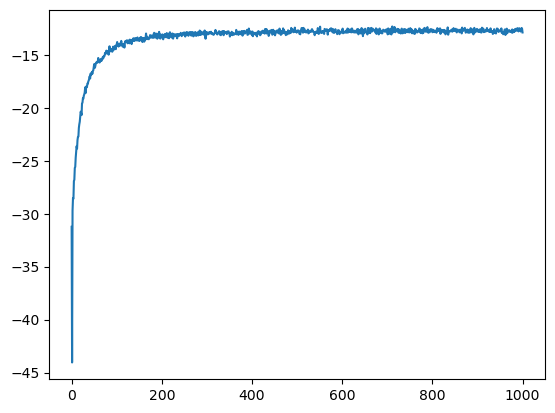

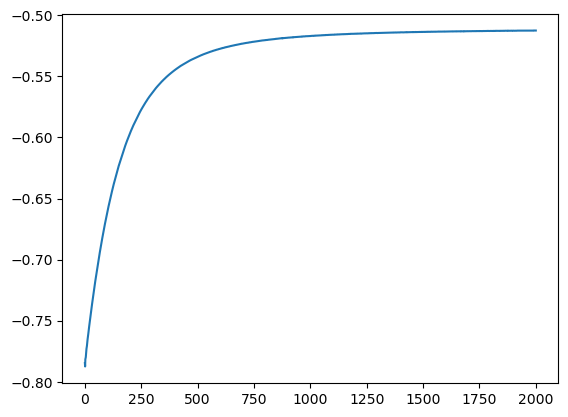

-0.5124964528808873
-12.895929044170279


In [6]:

plt.plot(rec_model.LLs[:])
plt.show()
plt.plot(rec_model.gen_model.LLs[:])
plt.show()
print(rec_model.gen_model.LLs[-1])
print(rec_model.LLs[-1])

# plt.plot(rec_model.dRs, label=['max', 'min'])
# plt.xlabel('step')
# plt.ylabel('dR')
# plt.legend()
# plt.show()

# plt.plot(rec_model.dWs, label=['max', 'min'])
# plt.xlabel('step')
# plt.ylabel('dW')
# plt.legend()
# plt.show()

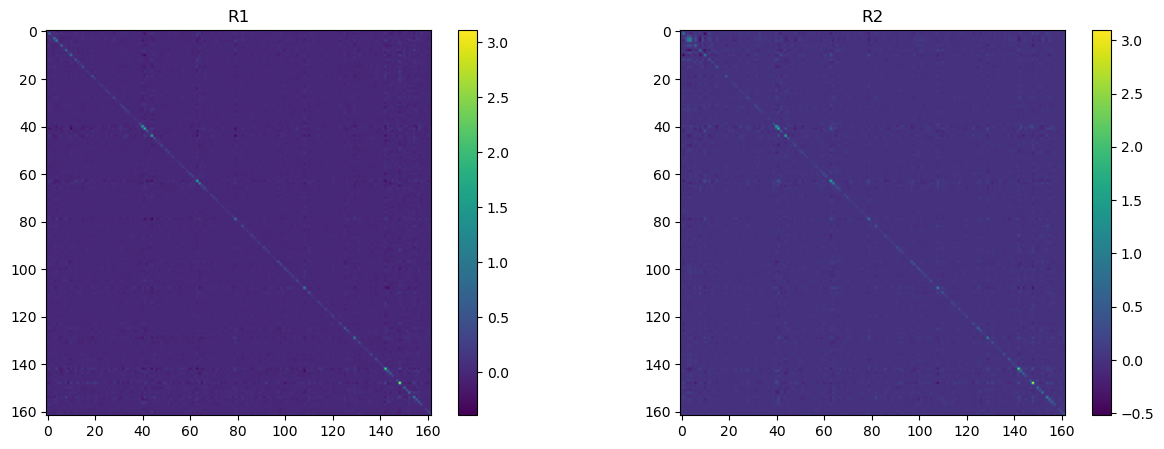

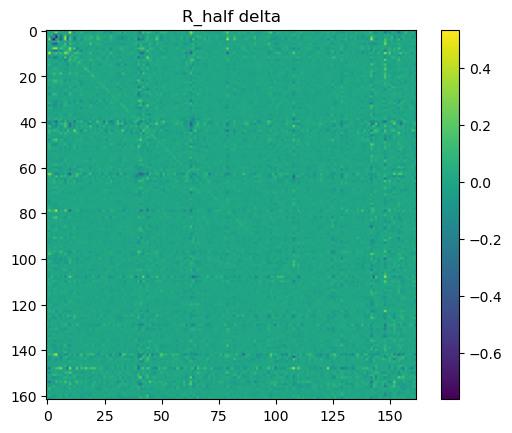

In [20]:
model1 = dill.load(open('4g10datamodels/full_R.pkl', 'rb'))
# model1 = dill.load(open('4g10datamodels/third.pkl', 'rb'))
model2 = dill.load(open('4g10datamodels/new_full_R.pkl', 'rb'))
# model2 = rec_model.gen_model
# model2 = model

# # Compare A, W, B, R_half, mu0, Sigma0_half through imshow plots
# # A
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].imshow(model1.A.squeeze(0).detach().cpu().numpy())
# ax[0].set_title('A1')
# ax[1].imshow(model2.A.squeeze(0).detach().cpu().numpy())
# ax[1].set_title('A2')
# plt.show()

# # W
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].imshow(model1.W.squeeze(0).detach().cpu().numpy())
# ax[0].set_title('W1')
# ax[1].imshow(model2.W.squeeze(0).detach().cpu().numpy())
# ax[1].set_title('W2')
# plt.show()

# # B
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].imshow(model1.B.squeeze(0).detach().cpu().numpy())
# ax[0].set_title('B1')
# ax[1].imshow(model2.B.squeeze(0).detach().cpu().numpy())
# ax[1].set_title('B2')
# plt.show()

# R_half
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].imshow(model1.R_half.squeeze(0).detach().cpu().numpy())
R1 = (model1.R_half @ model1.R_half.transpose(-1, -2)).detach().cpu().numpy()
im1 = ax[0].imshow(R1)
ax[0].set_title('R1')
# im2 = ax[1].imshow(model2.R_half.squeeze(0).detach().cpu().numpy())
R2 = model2.R.squeeze(0).detach().cpu().numpy()
im2 = ax[1].imshow(R2)
ax[1].set_title('R2')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
plt.show()

plt.imshow(R1 - R2)
plt.colorbar()
plt.title('R_half delta')
plt.show()

# # mu0
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].plot(model1.mu0.squeeze(0).detach().cpu().numpy())
# ax[0].set_title('mu01')
# ax[1].plot(model2.mu0.squeeze(0).detach().cpu().numpy())
# ax[1].set_title('mu02')
# plt.show()

# # Sigma0_half
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].imshow(model1.Sigma0_half.squeeze(0).detach().cpu().numpy())
# ax[0].set_title('Sigma0_half1')
# ax[1].imshow(model2.Sigma0_half.squeeze(0).detach().cpu().numpy())
# ax[1].set_title('Sigma0_half2')
# plt.show()
